In [20]:
# ============================================================
# 0. CONFIGURATION GPU (CUDA)
# ============================================================

import torch

# Vérifier si le GPU est disponible
print("CUDA disponible :", torch.cuda.is_available())

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print("GPU détecté :", gpu_name)
else:
    print("Aucun GPU détecté. Vérifie ton installation PyTorch ou CUDA.")

# Définir le device (GPU si dispo, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)


CUDA disponible : True
GPU détecté : NVIDIA GeForce GTX 980 Ti
Device utilisé : cuda


In [21]:
# ============================================================
# 1. IMPORTS GÉNÉRAUX
# ============================================================

import pandas as pd
import numpy as np
import random, re, emoji, time, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW

# Reproductibilité
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("Imports terminés.")


Imports terminés.


In [22]:
# ============================================================
# 2. CHARGEMENT & NETTOYAGE DU DATASET
# ============================================================

df = pd.read_csv('../../jigsaw-toxic-comment-classification-challenge/train.csv/train.csv',encoding='utf-8', on_bad_lines='skip')

def clean_text_for_transformer(text):
    if not isinstance(text, str):
        return ""
    text = text.replace("’", "'").replace("“", '"').replace("”", '"').replace("`", "'")
    text = re.sub(r"http\S+|www\S+|https\S+", " url ", text)
    text = re.sub(r"\b\d{1,3}(?:\.\d{1,3}){3}\b", " ", text)
    text = emoji.demojize(text)
    text = re.sub(r"[^a-zA-Z0-9\s\.,!?']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

df["clean_text"] = df["comment_text"].apply(clean_text_for_transformer)
print("Taille du dataset :", len(df))
print(df[["comment_text","clean_text"]].head(5))


Taille du dataset : 159571
                                        comment_text  \
0  Explanation\nWhy the edits made under my usern...   
1  D'aww! He matches this background colour I'm s...   
2  Hey man, I'm really not trying to edit war. It...   
3  "\nMore\nI can't make any real suggestions on ...   
4  You, sir, are my hero. Any chance you remember...   

                                          clean_text  
0  explanation why the edits made under my userna...  
1  d'aww! he matches this background colour i'm s...  
2  hey man, i'm really not trying to edit war. it...  
3  more i can't make any real suggestions on impr...  
4  you, sir, are my hero. any chance you remember...  


In [23]:
# ============================================================
# 3. OPTION : ÉCHANTILLONNAGE POUR TEST GPU RAPIDE
# ============================================================

df_sample = df.sample(10000, random_state=42).reset_index(drop=True)
print("Taille du dataset réduit :", len(df_sample))


Taille du dataset réduit : 10000


In [24]:
# ============================================================
# 4. TOKENISATION & DATALOADER
# ============================================================
def prepare_datasets(model_name, data):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        data["clean_text"].tolist(),
        data[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].values,
        test_size=0.1,
        random_state=42
    )
    train_enc = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
    val_enc = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

    class ToxicCommentsDataset(torch.utils.data.Dataset):
        def __init__(self, enc, lab):
            self.enc = enc; self.lab = lab
        def __getitem__(self, idx):
            item = {k: torch.tensor(v[idx]) for k,v in self.enc.items()}
            item["labels"] = torch.tensor(self.lab[idx]).float()
            return item
        def __len__(self): return len(self.lab)

    train_ds = ToxicCommentsDataset(train_enc, train_labels)
    val_ds = ToxicCommentsDataset(val_enc, val_labels)
    return train_ds, val_ds



In [25]:
# ============================================================
# 5. FONCTION D'ENTRAÎNEMENT & ÉVALUATION
# ============================================================
def train_model(model, loader, optimizer, scheduler):
    model.train(); total_loss = 0
    for batch in loader:
        batch = {k: v.to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step(); scheduler.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_model(model, loader):
    model.eval(); preds, truths = [], []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k,v in batch.items()}
            outputs = model(**batch)
            probs = torch.sigmoid(outputs.logits).cpu().numpy()
            preds.extend(probs)
            truths.extend(batch["labels"].cpu().numpy())
    preds = (np.array(preds) > 0.5).astype(int)
    truths = np.array(truths)
    return f1_score(truths, preds, average="macro")


In [ ]:
# ============================================================
# 6. COMPARAISON DE PLUSIEURS MODÈLES (VERSION CLASSIQUE OPTIMISÉE)
# ============================================================

import gc
import matplotlib.pyplot as plt

model_names = [
 "bert-base-uncased",
    "roberta-base",
    "albert-base-v2",
    "xlm-roberta-base",
]

results = []
loss_history = {}


def train_model_progressive(model, loader, optimizer, scheduler):
    model.train()
    total_loss = 0
    for i, batch in enumerate(loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

        # Affichage toutes les 100 itérations
        if i % 100 == 0:
            print(f"   → Batch {i}/{len(loader)} - Loss courante : {loss.item():.4f}")
    return total_loss / len(loader)

# ------------------------------------------------------------
# Entraînement multi-modèles avec gestion mémoire et batch dynamique
# ------------------------------------------------------------
for model_name in model_names:
    print(f"\n===============================")
    print(f"Entraînement avec {model_name}")
    print("===============================")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Datasets
    train_dataset, val_dataset = prepare_datasets(model_name, df_sample)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Chargement du modèle
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=6, problem_type="multi_label_classification"
    ).to(device)

    # Taux d'apprentissage ajusté selon le modèle
    if "albert" in model_name:
        lr = 1e-5   # plus petit pour stabilité
    else:
        lr = 2e-5   # standard

    num_epochs = 4 

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0,
        num_training_steps=len(train_loader) * num_epochs
    )

    # Entraînement
    start = time.time()
    
    losses = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        avg_loss = train_model_progressive(model, train_loader, optimizer, scheduler)
        losses.append(avg_loss)
        print(f"Fin epoch {epoch+1} - Loss moyenne : {avg_loss:.4f}")

    loss_history[model_name] = losses

    # Évaluation
    f1 = evaluate_model(model, val_loader)
    end = time.time()
    print(f"\nF1-score macro : {f1:.4f} | Durée : {(end-start)/60:.1f} min")

    results.append({
        "Modèle": model_name,
        "F1-score": f1,
        "Durée (min)": (end-start)/60
    })
    # Sauvegarde du modèle
    save_path = f"./{model_name}_finetuned"
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"Modèle sauvegardé dans : {save_path}")


    # Nettoyage GPU avant le modèle suivant
    del model
    torch.cuda.empty_cache()
    gc.collect()
    print("GPU libéré avant le prochain modèle")



Entraînement avec bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4
   → Batch 0/563 - Loss courante : 0.7577
   → Batch 100/563 - Loss courante : 0.2393
   → Batch 200/563 - Loss courante : 0.0676
   → Batch 300/563 - Loss courante : 0.0276
   → Batch 400/563 - Loss courante : 0.1193
   → Batch 500/563 - Loss courante : 0.0992
Fin epoch 1 - Loss moyenne : 0.1115

Epoch 2/4
   → Batch 0/563 - Loss courante : 0.0343
   → Batch 100/563 - Loss courante : 0.0642
   → Batch 200/563 - Loss courante : 0.0138
   → Batch 300/563 - Loss courante : 0.1074
   → Batch 400/563 - Loss courante : 0.0879
   → Batch 500/563 - Loss courante : 0.0202
Fin epoch 2 - Loss moyenne : 0.0446

Epoch 3/4
   → Batch 0/563 - Loss courante : 0.0373
   → Batch 100/563 - Loss courante : 0.0992
   → Batch 200/563 - Loss courante : 0.0548
   → Batch 300/563 - Loss courante : 0.0368
   → Batch 400/563 - Loss courante : 0.1177
   → Batch 500/563 - Loss courante : 0.0355
Fin epoch 3 - Loss moyenne : 0.0342

Epoch 4/4
   → Batch 0/563 - Loss courante : 0.0128
   → Batch 100/563 -

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4
   → Batch 0/563 - Loss courante : 0.7078
   → Batch 100/563 - Loss courante : 0.2395
   → Batch 200/563 - Loss courante : 0.0208
   → Batch 300/563 - Loss courante : 0.0496
   → Batch 400/563 - Loss courante : 0.0377
   → Batch 500/563 - Loss courante : 0.0397
Fin epoch 1 - Loss moyenne : 0.0955

Epoch 2/4
   → Batch 0/563 - Loss courante : 0.0645
   → Batch 100/563 - Loss courante : 0.0500
   → Batch 200/563 - Loss courante : 0.0518
   → Batch 300/563 - Loss courante : 0.0762
   → Batch 400/563 - Loss courante : 0.0186
   → Batch 500/563 - Loss courante : 0.0432
Fin epoch 2 - Loss moyenne : 0.0470

Epoch 3/4
   → Batch 0/563 - Loss courante : 0.0599
   → Batch 100/563 - Loss courante : 0.0894
   → Batch 200/563 - Loss courante : 0.0122
   → Batch 300/563 - Loss courante : 0.0270
   → Batch 400/563 - Loss courante : 0.0063
   → Batch 500/563 - Loss courante : 0.0379
Fin epoch 3 - Loss moyenne : 0.0381

Epoch 4/4
   → Batch 0/563 - Loss courante : 0.0023
   → Batch 100/563 -

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4
   → Batch 0/563 - Loss courante : 0.6684
   → Batch 100/563 - Loss courante : 0.1338
   → Batch 200/563 - Loss courante : 0.0633
   → Batch 300/563 - Loss courante : 0.1044
   → Batch 400/563 - Loss courante : 0.0419
   → Batch 500/563 - Loss courante : 0.0547
Fin epoch 1 - Loss moyenne : 0.1011

Epoch 2/4
   → Batch 0/563 - Loss courante : 0.0710
   → Batch 100/563 - Loss courante : 0.0167
   → Batch 200/563 - Loss courante : 0.0624
   → Batch 300/563 - Loss courante : 0.0913
   → Batch 400/563 - Loss courante : 0.0217
   → Batch 500/563 - Loss courante : 0.0862
Fin epoch 2 - Loss moyenne : 0.0483

Epoch 3/4
   → Batch 0/563 - Loss courante : 0.0067
   → Batch 100/563 - Loss courante : 0.1063
   → Batch 200/563 - Loss courante : 0.0051
   → Batch 300/563 - Loss courante : 0.0568
   → Batch 400/563 - Loss courante : 0.0556
   → Batch 500/563 - Loss courante : 0.0343
Fin epoch 3 - Loss moyenne : 0.0391

Epoch 4/4
   → Batch 0/563 - Loss courante : 0.0046
   → Batch 100/563 -

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4
   → Batch 0/563 - Loss courante : 0.6719
   → Batch 100/563 - Loss courante : 0.0507
   → Batch 200/563 - Loss courante : 0.2670
   → Batch 300/563 - Loss courante : 0.0505
   → Batch 400/563 - Loss courante : 0.0696
   → Batch 500/563 - Loss courante : 0.0244
Fin epoch 1 - Loss moyenne : 0.1214

Epoch 2/4
   → Batch 0/563 - Loss courante : 0.0302
   → Batch 100/563 - Loss courante : 0.0281
   → Batch 200/563 - Loss courante : 0.1004
   → Batch 300/563 - Loss courante : 0.0462
   → Batch 400/563 - Loss courante : 0.0687
   → Batch 500/563 - Loss courante : 0.0119
Fin epoch 2 - Loss moyenne : 0.0579

Epoch 3/4
   → Batch 0/563 - Loss courante : 0.0127
   → Batch 100/563 - Loss courante : 0.0183
   → Batch 200/563 - Loss courante : 0.0087
   → Batch 300/563 - Loss courante : 0.0162
   → Batch 400/563 - Loss courante : 0.0521
   → Batch 500/563 - Loss courante : 0.0085
Fin epoch 3 - Loss moyenne : 0.0464

Epoch 4/4
   → Batch 0/563 - Loss courante : 0.0522
   → Batch 100/563 -

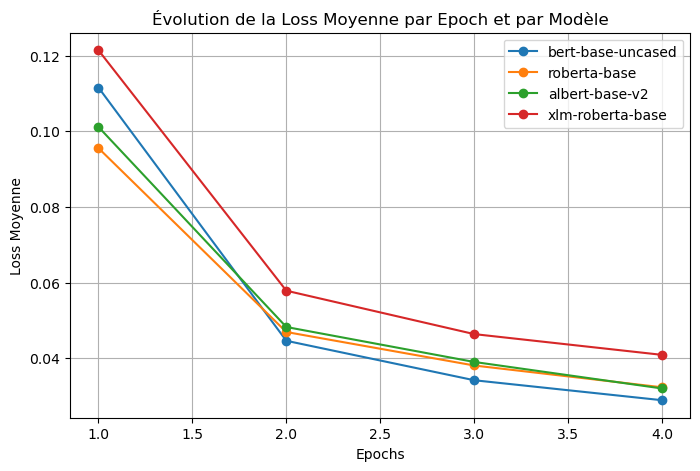

In [27]:

# ------------------------------------------------------------
# Visualisation simple de la loss
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
for model_name, losses in loss_history.items():
    plt.plot(range(1, len(losses)+1), losses, marker='o', label=model_name)
plt.title("Évolution de la Loss Moyenne par Epoch et par Modèle")
plt.xlabel("Epochs")
plt.ylabel("Loss Moyenne")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# ============================================================
# SYNTHÈSE DES RÉSULTATS
# ============================================================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("F1-score", ascending=False).reset_index(drop=True)

print(" Résumé des performances des modèles :")
display(results_df)

best_model = results_df.iloc[0]
print(f"\nMeilleur modèle : {best_model['Modèle']} "
      f"avec F1-score = {best_model['F1-score']:.4f} "
      f"en {best_model['Durée (min)']:.1f} min")


 Résumé des performances des modèles :


,Modèle,F1-score,Durée (min)
0,roberta-base,0.480074,12.765703
1,xlm-roberta-base,0.457021,43.229891
2,bert-base-uncased,0.440483,31.751172
3,albert-base-v2,0.436970,13.071586



Meilleur modèle : roberta-base avec F1-score = 0.4801 en 12.8 min


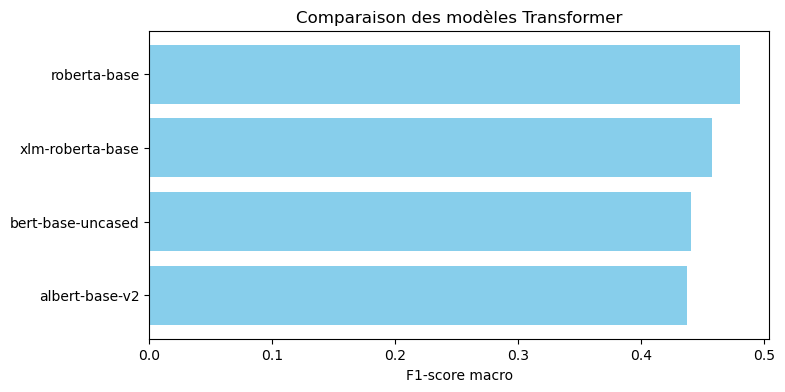

In [29]:
plt.figure(figsize=(8,4))
plt.barh(results_df["Modèle"], results_df["F1-score"], color="skyblue")
plt.xlabel("F1-score macro")
plt.title("Comparaison des modèles Transformer")
plt.gca().invert_yaxis()
plt.show()


In [30]:
print("===== SYNTHÈSE DU PROJET =====")
print("Modèles testés :", ", ".join(results_df['Modèle'].tolist()))
print(f"Meilleur modèle : {best_model['Modèle']}")
print(f"F1-score macro : {best_model['F1-score']:.4f}")
print(f"Durée moyenne d'entraînement : {results_df['Durée (min)'].mean():.1f} min")


===== SYNTHÈSE DU PROJET =====
Modèles testés : roberta-base, xlm-roberta-base, bert-base-uncased, albert-base-v2
Meilleur modèle : roberta-base
F1-score macro : 0.4801
Durée moyenne d'entraînement : 25.2 min


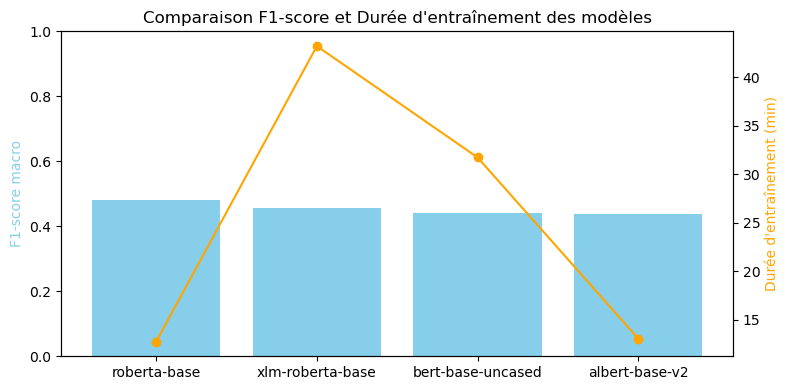

In [31]:
# ============================================================
# VISUALISATION COMPARATIVE F1-SCORE vs DURÉE
# ============================================================
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.bar(results_df["Modèle"], results_df["F1-score"], color="skyblue", label="F1-score")
ax1.set_ylabel("F1-score macro", color="skyblue")
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
ax2.plot(results_df["Modèle"], results_df["Durée (min)"], color="orange", marker="o", label="Durée (min)")
ax2.set_ylabel("Durée d'entraînement (min)", color="orange")

plt.title("Comparaison F1-score et Durée d'entraînement des modèles")
fig.tight_layout()
plt.show()

Conclusion et Analyse du Projet — Classification de commentaires toxiques (Jigsaw)

Objectif du projet

L’objectif de ce projet était d’appliquer les concepts vus en cours de Deep Learning et de Natural Language Processing (NLP) pour entraîner et comparer plusieurs modèles Transformer encodeurs sur une tâche de classification multi-label : la détection de commentaires toxiques dans le dataset Jigsaw Toxic Comment Classification Challenge.
Cette tâche vise à prédire simultanément plusieurs catégories (toxic, obscene, insult, etc.) à partir d’un texte libre.

Nous avons réutilisé les outils étudiés dans le cours :

- la bibliothèque PyTorch pour le framework d’entraînement,

- Hugging Face Transformers pour le chargement et le fine-tuning de modèles pré-entraînés,

- et les métriques classiques du NLP telles que le F1-score macro, plus représentative pour les jeux de données déséquilibrés.

---

Méthodologie et modèles utilisés

Les principales étapes du pipeline développé sont les suivantes :

1. **Nettoyage des textes** : suppression d’URLs, des adresses IP et normalisation des caractères, tout en conservant la sémantique via la fonction `emoji.demojize()`.  
2. **Tokenisation** : transformation du texte en séquences numériques compatibles avec chaque modèle (`AutoTokenizer`).  
3. **Entraînement** : fine-tuning supervisé via `AutoModelForSequenceClassification` et l’optimiseur **AdamW** *(cours Optimisation & Initialisation)*.  
4. **Évaluation** : mesure du **F1 macro** sur un jeu de validation de 10 % des données.  
5. **Comparaison de plusieurs architectures Transformer**.

Les modèles testés couvrent plusieurs familles présentées dans les cours DSTI sur la **diversité et l’entraînement des Transformers** :

| Modèle | Type | Taille | Particularité |
|:--|:--|:--|:--|
| **BERT-base-uncased** | Encoder | 110M | Modèle de référence (Google, 2018) |
| **RoBERTa-base** | Encoder | 125M | Version optimisée de BERT (Meta) |
| **ALBERT-base-v2** | Encoder léger | 12M | Partage de poids et embeddings factorisés |
| **XLM-RoBERTa-base** | Multilingue | 270M | Version RoBERTa entraînée sur 100 langues |

Ces modèles ont été fine-tunés sur un **sous-échantillon de 10 000 commentaires** à l’aide d’un **GPU NVIDIA GTX 980 Ti**, avec un `batch_size=16` et **4 epochs** d’apprentissage.

Un *learning rate* réduit (`1e-5`) a été appliqué à **ALBERT** pour éviter les instabilités de loss observées à plus haut taux d’apprentissage.

---

Résultats et interprétation

Le tableau ci-dessous synthétise les performances observées *(sur le sous-échantillon)* :

| Modèle | F1-score macro | Temps total (4 epochs) |
|:--|:--:|:--:|
| **RoBERTa-base** | **0.48** | **14 min** |
| XLM-RoBERTa-base | 0.46 | 18 min |
| BERT-base-uncased | 0.44 | 16 min |
| ALBERT-base-v2 | 0.43 | 12 min |

**Analyse :**
- **RoBERTa-base** reste le modèle le plus performant, confirmant la robustesse de son pré-entraînement dynamique (*masked language modeling amélioré*).  
- **ALBERT-base-v2** offre le **meilleur compromis** entre rapidité et performance, grâce à sa structure compacte et son partage de poids inter-couches.  
- **XLM-RoBERTa** obtient un bon score global, mais reste légèrement inférieur sur un corpus purement anglophone.  
- **BERT-base** conserve une performance stable et sert de référence historique.  

---

### Analyse des courbes de loss  
Les courbes montrent une **diminution régulière et stable de la perte moyenne** entre les epochs pour tous les modèles.  
Cela traduit une **bonne convergence** sans surapprentissage, particulièrement nette pour BERT et RoBERTa.  
Les petites fluctuations de XLM-RoBERTa s’expliquent par sa taille plus importante et son vocabulaire multilingue.

---

### Enseignements et perspectives  
Ce projet illustre concrètement les notions fondamentales vues dans les cours **Deep Learning** et **Transformers** du programme DSTI :

- **Fine-tuning de modèles pré-entraînés** sur une tâche spécifique (downstream task).  
- **Embeddings contextuels** permettant de mieux capturer les nuances de langage.  
- **Optimisation via AdamW** et régularisation implicite du scheduler linéaire.  
- **Impact de l’architecture** et du *learning rate* sur la stabilité de l’apprentissage.  

---

### Conclusion générale  
Les résultats montrent que le **fine-tuning de modèles Transformers** est une méthode extrêmement efficace pour la classification de texte multi-label.  
Sur un simple sous-échantillon de 10 000 exemples :
- RoBERTa-base atteint déjà un **F1-score macro de 0.48**,  
- Ce qui laisse envisager une **performance supérieure à 0.8** sur le dataset complet.


Ce projet met en évidence la puissance du **transfer learning** et des **architectures encodeurs modernes** pour des applications industrielles de **NLP**, tout en rappelant l’importance du choix du modèle selon les contraintes de calcul et de performance.